In [1]:
!pip3 install --upgrade tables
!pip3 install keras-tcn --no-dependencies

     |████████████████████████████████| 4.3 MB 5.0 MB/s 
  Attempting uninstall: tables
    Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [1]:
%cd '/content/drive/MyDrive/ColabNotebooks/TSGANs/TimeGAN_TF2'

/content/drive/MyDrive/ColabNotebooks/TSGANs/TimeGAN_TF2


Automatic pdb calling has been turned OFF


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "TCN_Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 24, 10)]          0         
                                                                 
 TCN_Encoder (Functional)    (None, 4, 8)              76588     
                                                                 
 TCN_Decoder (Functional)    (None, 24, 10)            75790     
                                                                 
Total params: 152,378
Trainable params: 152,378
Non-trainable params: 0
_________________________________________________________________
Model: "TCN_Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 24, 10)]          0         
                                                                 
 tcn-enc (TCN)          

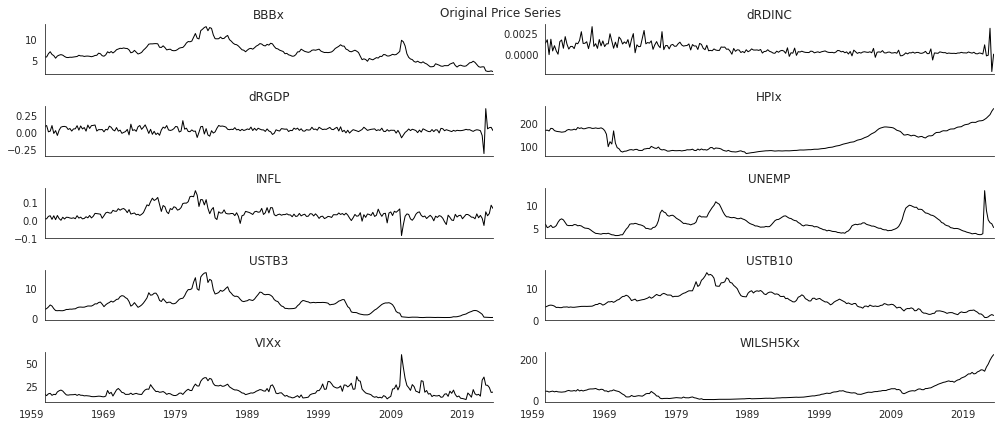

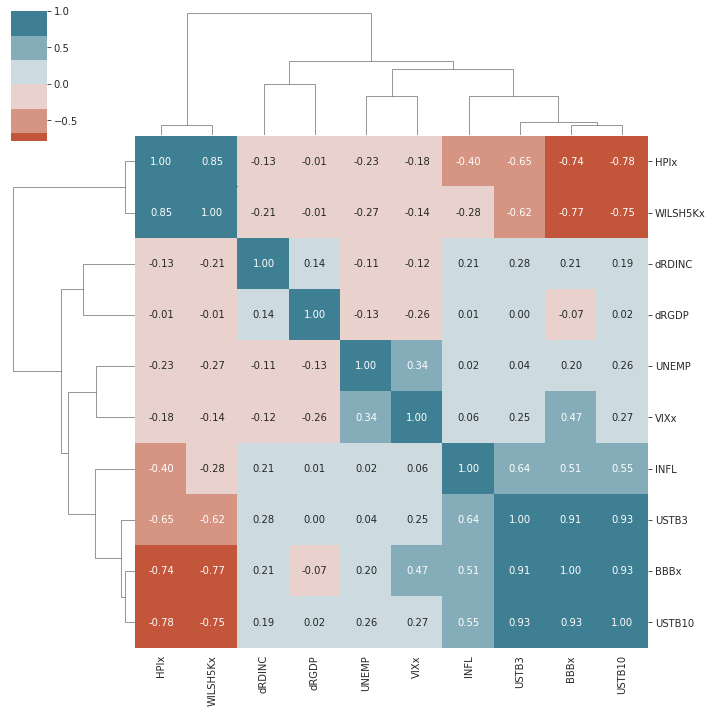


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/bdb.py", line 332, in set_trace
    sys.settrace(self.trace_dispatch)



> /content/drive/MyDrive/ColabNotebooks/TSGANs/TimeGAN_TF2/tcn_timegan/src/run_tcn.py(75)<module>()
-> scaler = MinMaxScaler()
(Pdb) q



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/bdb.py", line 357, in set_quit
    sys.settrace(None)



BdbQuit: ignored

<Figure size 432x288 with 0 Axes>

In [2]:
%pdb off
%run ./tcn_timegan/src/run_tcn.py

# Generate Synthetic Data

## Get imports

In [ ]:
%cd '/content/drive/MyDrive/ColabNotebooks/TSGANs/TimeGAN_TF2/tcn_timegan/src'

/content/drive/MyDrive/ColabNotebooks/TSGANs/TimeGAN_TF2/tcn_timegan/src


In [ ]:
from add_fns import make_random_data 
from params import (experiment,
                    batch_size, n_seq, seq_len,
                    data_name, synthetic_data_name)

from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import plot_model

import os, re

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

## Load real data

In [ ]:
%cd '/content/drive/MyDrive/ColabNotebooks/TSGANs/TimeGAN_TF2'

/content/drive/MyDrive/ColabNotebooks/TSGANs/TimeGAN_TF2


In [ ]:
results_path = Path('./tcn_timegan')
log_dir = results_path / f'experiment_{experiment:02}'
sample_dir = log_dir / 'samples'
hdf_store = results_path / 'TimeSeriesGAN.h5'
df = pd.read_hdf(hdf_store, data_name)
tickers = list(df.columns)

## Scale real data

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

In [ ]:
scaled_data.shape

(251, 10)

## Generate synthetic data

In [ ]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat()) 

synthetic_data = tf.keras.models.load_model(log_dir / synthetic_data_name)
synthetic_data.summary()                                         

Model: "SyntheticData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 10)]          0         
                                                                 
 TCN_Encoder (Functional)    (None, 4, 8)              76588     
                                                                 
 Supervisor (Sequential)     (None, 4, 8)              936       
                                                                 
 TCN_Decoder (Functional)    (None, 24, 10)            75790     
                                                                 
Total params: 153,314
Trainable params: 153,314
Non-trainable params: 0
_________________________________________________________________


In [ ]:
generated_data = []
n_windows = len(df) - seq_len
for i in range(n_windows):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

len(generated_data)

227

In [ ]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(29056, 24, 10)

In [ ]:
res = [i.start() for i in re.finditer('/', data_name)]
gen_data_fname = 'gen_' + data_name[res[-1] + 1:] 
np.save(log_dir / gen_data_fname, generated_data) 

## Rescale generated data

In [ ]:
generated_data = (scaler.inverse_transform(generated_data.reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
generated_data.shape

(29056, 24, 10)

## Persist Data

In [ ]:
hdf_store

PosixPath('tcn_timegan/TimeSeriesGAN.h5')

In [ ]:
gendata_hdf_name = 'data/' + f'experiment_{experiment:02d}/' + synthetic_data_name
pd.DataFrame(generated_data.reshape(-1, n_seq), columns=tickers).to_hdf(hdf_store, gendata_hdf_name)

In [ ]:
with pd.HDFStore(hdf_store) as store:
    store.put('data/' + f'experiment_{experiment:02d}/' + gendata_hdf_name, pd.DataFrame(generated_data.reshape(-1, n_seq),
                                             columns=tickers))

## Plot sample Series


Sample Plot: 1


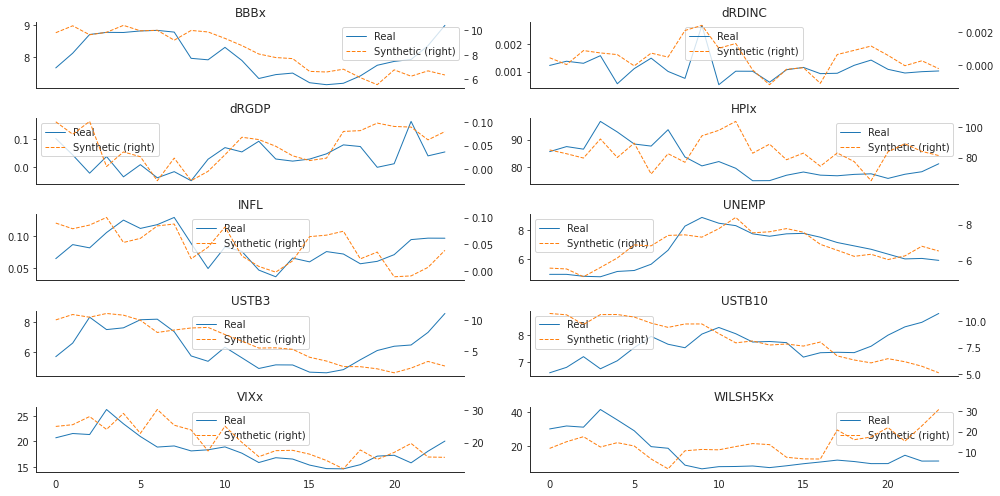


Sample Plot: 2


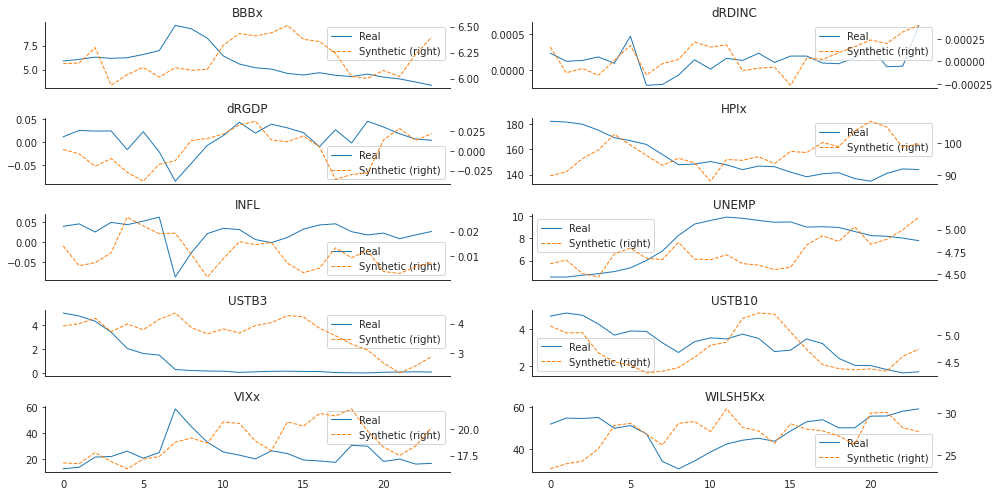


Sample Plot: 3


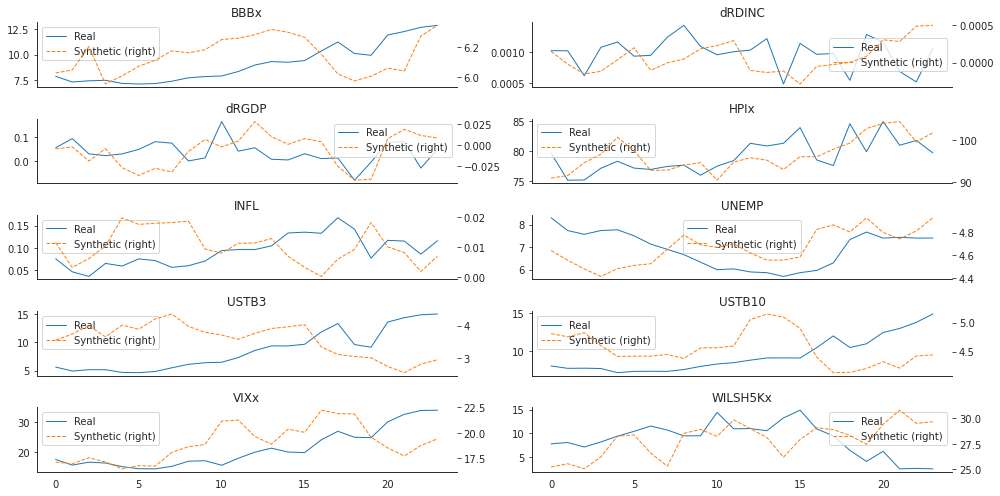


Sample Plot: 4


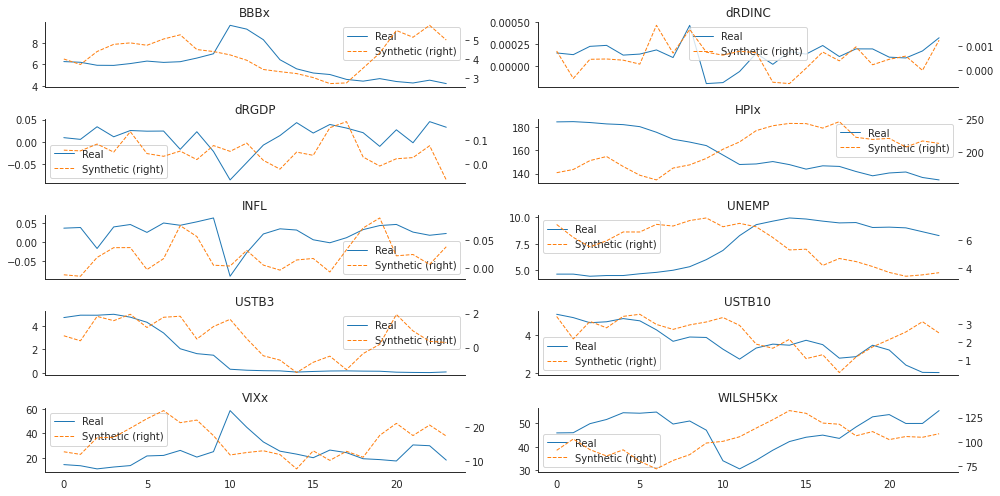


Sample Plot: 5


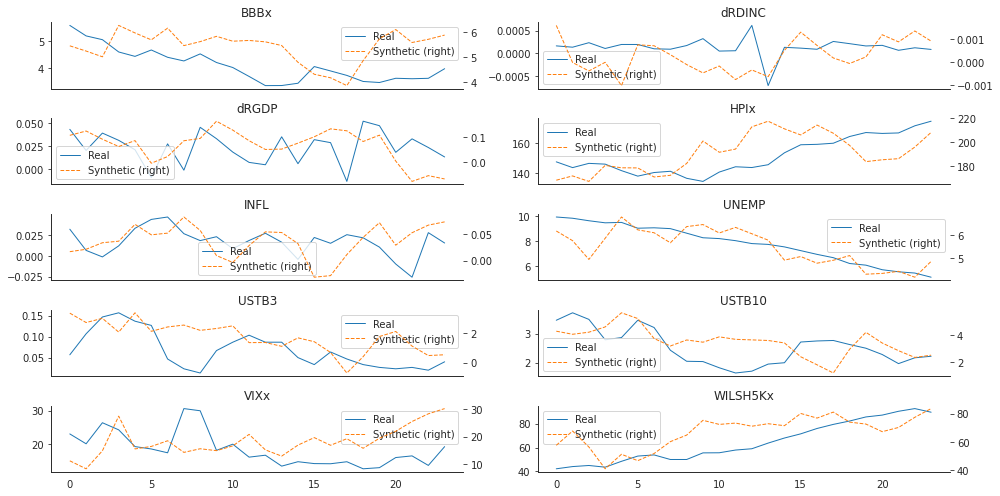


Sample Plot: 6


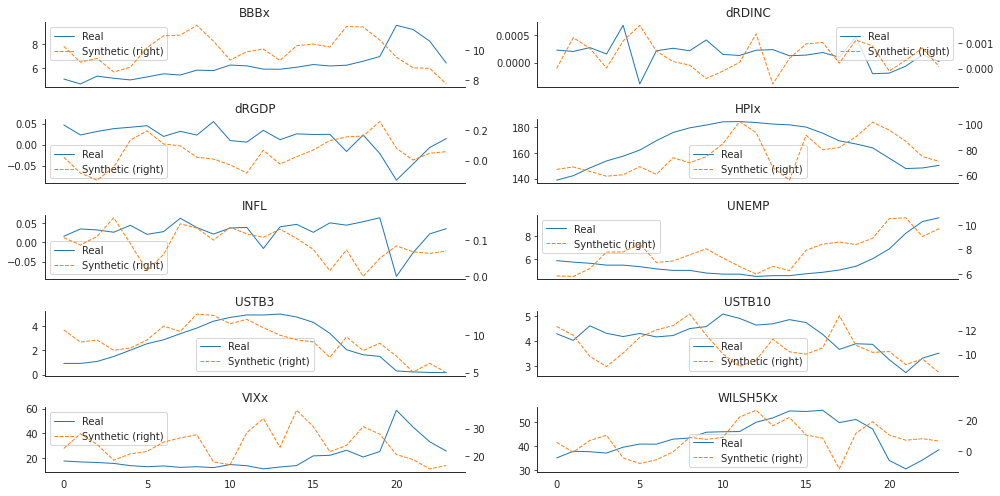


Sample Plot: 7


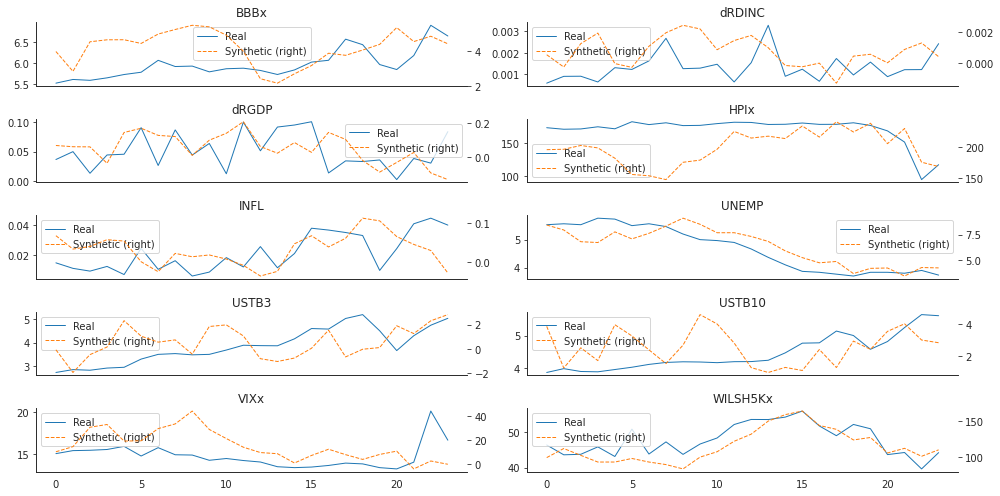


Sample Plot: 8


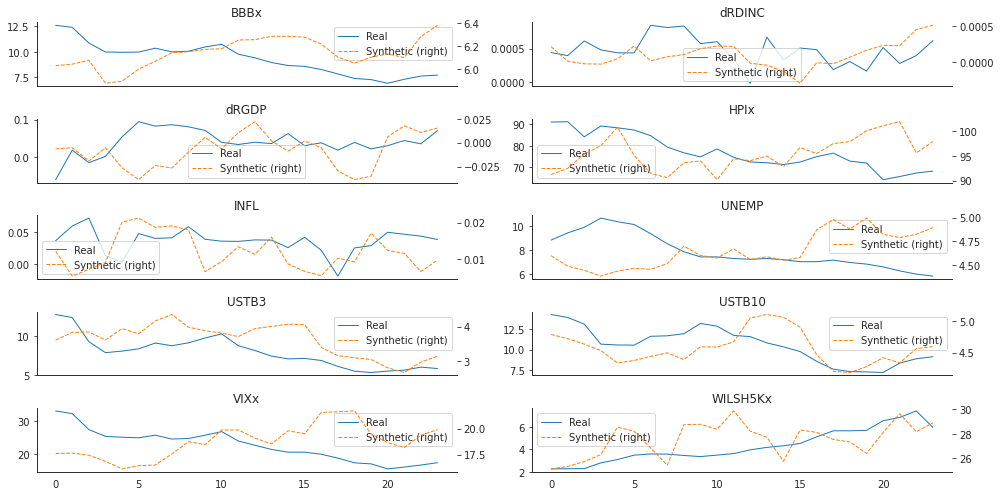


Sample Plot: 9


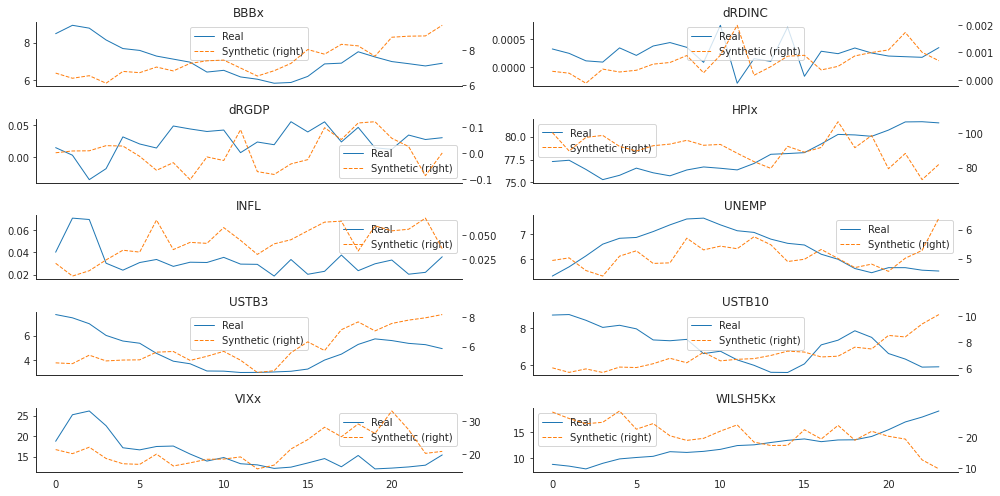


Sample Plot: 10


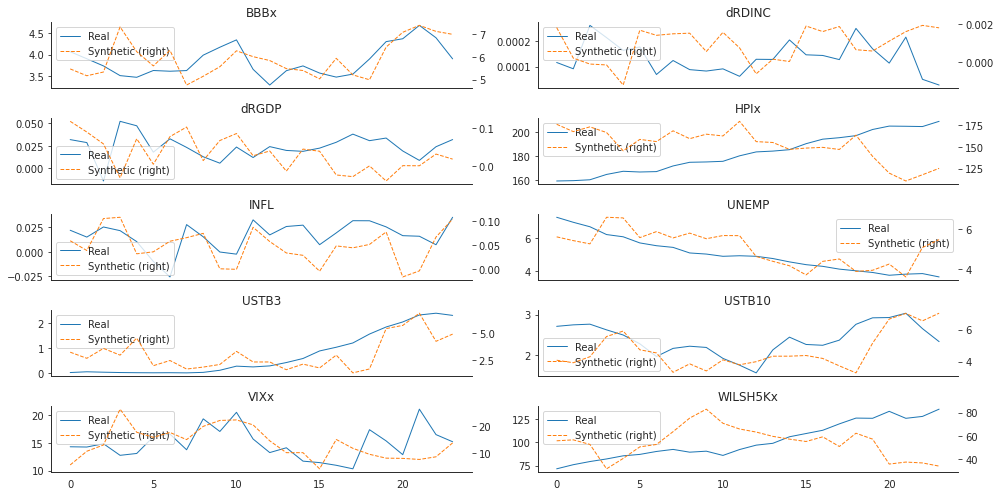

In [ ]:
n_init = 0
n_plots = 10

for n in range(n_init, n_init + n_plots):
  print("\nSample Plot: %d" % (n + 1))
  fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 7))
  axes = axes.flatten()

  #index = list(range(1, 25))
  synthetic = generated_data[np.random.randint(n_windows)]

  idx = np.random.randint(len(df) - seq_len)
  #idx = np.random.randint(generated_data.shape[0] - batch_size)
  real = df.iloc[idx: idx + seq_len]
  #synthetic = generated_data[idx, :, :]

  for j, ticker in enumerate(list(df.columns)):
      (pd.DataFrame({'Real': real.iloc[:, j].values,
                    'Synthetic': synthetic[:, j]})
      .plot(ax=axes[j],
            title=ticker,
            secondary_y='Synthetic', style=['-', '--'],
            lw=1))
  sns.despine()

  fig.tight_layout()
  plt.show()
  f_name = os.path.join(sample_dir, "sample_" + str(n + 1 ) + ".png")
  fig.savefig(f_name)

# Load Data

In [ ]:
data = []
for i in range(len(df) - seq_len):
    data.append(scaled_data[i:i + seq_len])

n_windows = len(data)
print(n_windows)

227


In [ ]:
gen_data_fname

'gen_stress_vars_df'

In [ ]:
real_data = data

In [ ]:
synthetic_data = np.load(results_path / f'experiment_{experiment:02d}' / (gen_data_fname + '.npy'))
synthetic_data.shape

(29056, 24, 10)

# Prepare Sample

In [ ]:
sample_size = 250
idx = np.random.permutation(len(real_data))[:sample_size]

In [ ]:
# Data preprocessing
real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(synthetic_data)[idx]

In [ ]:
real_sample.shape

(227, 24, 10)

In [ ]:
real_sample_2d = real_sample.reshape(-1, seq_len)
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)

In [ ]:
real_sample_2d.shape, synthetic_sample_2d.shape

((2270, 24), (2270, 24))

# Visualization in 2D: A Qualitative Assessment of Diversity

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os

## Run PCA

In [ ]:
pca = PCA(n_components=2)
pca.fit(real_sample_2d)
pca_real = (pd.DataFrame(pca.transform(real_sample_2d))
            .assign(Data='Real'))
pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d))
                 .assign(Data='Synthetic'))
pca_result = pca_real.append(pca_synthetic).rename(
    columns={0: '1st Component', 1: '2nd Component'})

In [ ]:
pca_synthetic.shape

(2270, 3)

## Run t-SNE

In [ ]:
tsne_data = np.concatenate((real_sample_2d,
                            synthetic_sample_2d), axis=0)

tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=40)
tsne_result = tsne.fit_transform(tsne_data)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4540 samples in 0.000s...
[t-SNE] Computed neighbors for 4540 samples in 0.444s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4540
[t-SNE] Computed conditional probabilities for sample 2000 / 4540
[t-SNE] Computed conditional probabilities for sample 3000 / 4540
[t-SNE] Computed conditional probabilities for sample 4000 / 4540
[t-SNE] Computed conditional probabilities for sample 4540 / 4540
[t-SNE] Mean sigma: 0.095185
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.113956
[t-SNE] KL divergence after 1000 iterations: 0.380453


In [ ]:
tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
tsne_result.loc[sample_size*6:, 'Data'] = 'Synthetic'

## Plot Result

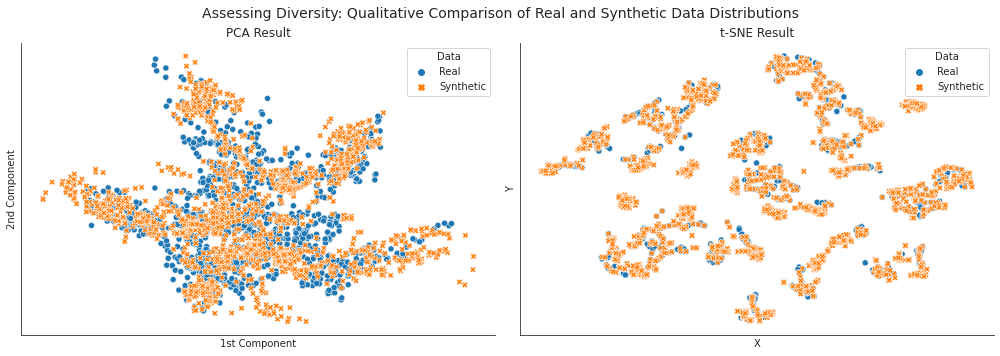

In [ ]:
sample_num = 2

fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                hue='Data', style='Data', ax=axes[0])
sns.despine()
axes[0].set_title('PCA Result')


sns.scatterplot(x='X', y='Y',
                data=tsne_result,
                hue='Data', 
                style='Data', 
                ax=axes[1])
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions', 
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);
f_name = os.path.join(log_dir, "evals", "distrib_sample_" + str(sample_num) + ".png")
fig.savefig(f_name)

# Time Series Classification: A quantitative Assessment of Fidelity

## Prepare Data

In [ ]:
[len(real_data), real_data[0].shape]

[227, (24, 10)]

In [ ]:
real_data = np.stack(real_data, axis=0)
real_data.shape

(227, 24, 10)

In [ ]:
synthetic_data.shape

(29056, 24, 10)

In [ ]:
n_series = real_data.shape[0]
idx = np.arange(n_series)

In [ ]:
n_train = int(.8*n_series)
train_idx = idx[:n_train]
test_idx = idx[n_train:]
n_test = len(test_idx)
[n_train, n_test]

[181, 46]

In [ ]:
train_data = np.vstack((real_data[train_idx], 
                        synthetic_data[train_idx]))
test_data = np.vstack((real_data[test_idx], 
                       synthetic_data[test_idx]))

In [ ]:
train_labels = np.concatenate((np.ones(n_train),
                               np.zeros(n_train)))
test_labels = np.concatenate((np.ones(n_test),
                              np.zeros(n_test)))

## Create Classifier

In [ ]:
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Sequential

In [ ]:
ts_classifier = Sequential([GRU(32, input_shape=(seq_len, n_seq), name='GRU'),   # 32 is a reasonable guess
                            Dense(1, activation='sigmoid', name='OUT')],
                           name='Time_Series_Classifier')

In [ ]:
ts_classifier.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=[AUC(name='AUC'), 'accuracy'])

In [ ]:
ts_classifier.summary()

Model: "Time_Series_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU (GRU)                   (None, 32)                4224      
                                                                 
 OUT (Dense)                 (None, 1)                 33        
                                                                 
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________


In [ ]:
result = ts_classifier.fit(x=train_data,
                           y=train_labels,
                           validation_data=(test_data, test_labels),
                           epochs=250,
                           batch_size=128,
                           verbose=0)

In [ ]:
ts_classifier.evaluate(x=test_data, y=test_labels)

3/3 [==============================] - 0s 5ms/step - loss: 4.3363 - AUC: 0.4991 - accuracy: 0.5326


[4.336268424987793, 0.49905475974082947, 0.532608687877655]

In [ ]:
history = pd.DataFrame(result.history)
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          250 non-null    float64
 1   AUC           250 non-null    float64
 2   accuracy      250 non-null    float64
 3   val_loss      250 non-null    float64
 4   val_AUC       250 non-null    float64
 5   val_accuracy  250 non-null    float64
dtypes: float64(6)
memory usage: 11.8 KB


In [ ]:
from matplotlib.ticker import FuncFormatter

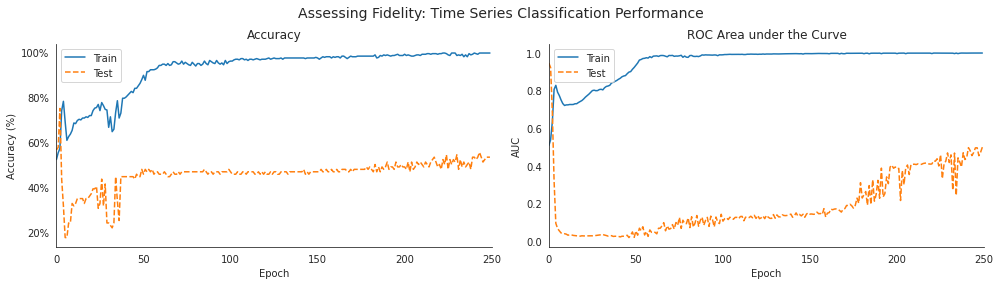

In [ ]:
sample_num = 1

sns.set_style('white')
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
history[['AUC', 'val_AUC']].rename(columns={'AUC': 'Train', 'val_AUC': 'Test'}).plot(ax=axes[1], 
                                                                                     title='ROC Area under the Curve',
                                                                                    style=['-', '--'],
                                                                                    xlim=(0, 250))
history[['accuracy', 'val_accuracy']].rename(columns={'accuracy': 'Train', 'val_accuracy': 'Test'}).plot(ax=axes[0], 
                                                                                                         title='Accuracy',
                                                                                                        style=['-', '--'],
                                                                                                        xlim=(0, 250))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')

axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[0].set_ylabel('Accuracy (%)')
axes[1].set_ylabel('AUC')
sns.despine()
fig.suptitle('Assessing Fidelity: Time Series Classification Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);
f_name = os.path.join(log_dir, "evals", "classify_sample_" + str(sample_num) + ".png")
fig.savefig(f_name)

# Train on Synthetic, test on real: Assessing usefulness

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
real_data.shape, synthetic_data.shape

((227, 24, 10), (29056, 24, 10))

In [ ]:
real_train_data = real_data[train_idx, :23, :]
real_train_label = real_data[train_idx, -1, :]

real_test_data = real_data[test_idx, :23, :]
real_test_label = real_data[test_idx, -1, :]

In [ ]:
real_train_data.shape, real_train_label.shape, real_test_data.shape, real_test_label.shape

((181, 23, 10), (181, 10), (46, 23, 10), (46, 10))

In [ ]:
synthetic_train = synthetic_data[train_idx, :23, :]
synthetic_label = synthetic_data[train_idx, -1, :]

In [ ]:
synthetic_train.shape, synthetic_label.shape

((181, 23, 10), (181, 10))

In [ ]:
def get_model():
    model = Sequential([GRU(12, input_shape=(seq_len - 1, n_seq)),
                        Dense(n_seq)])

    model.compile(optimizer=Adam(),
                  loss='MeanAbsoluteError')
                  #(name='MAE'))
    return model

In [ ]:
ts_regression = get_model()
synthetic_result = ts_regression.fit(x=synthetic_train,
                                     y=synthetic_label,
                                     validation_data=(
                                         real_test_data, 
                                         real_test_label),
                                     epochs=100,
                                     batch_size=128,
                                     verbose=0)

In [ ]:
ts_regression = get_model()
real_result = ts_regression.fit(x=real_train_data,
                                y=real_train_label,
                                validation_data=(
                                    real_test_data, 
                                    real_test_label),
                                epochs=100,
                                batch_size=128,
                                verbose=0)

In [ ]:
synthetic_result = pd.DataFrame(synthetic_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})
real_result = pd.DataFrame(real_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})

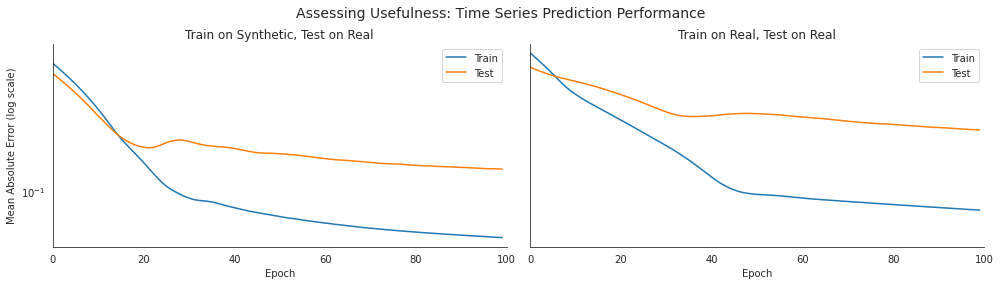

In [ ]:
sample_num = 1

sns.set_style('white')

fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)
synthetic_result.plot(ax=axes[0], title='Train on Synthetic, Test on Real', logy=True, xlim=(0, 100))
real_result.plot(ax=axes[1], title='Train on Real, Test on Real', logy=True, xlim=(0, 100))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Mean Absolute Error (log scale)')

sns.despine()
fig.suptitle('Assessing Usefulness: Time Series Prediction Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);
f_name = os.path.join(log_dir, "evals", "TSTR_sample_" + str(sample_num) + ".png")
fig.savefig(f_name)

In [ ]:
import h5py

In [ ]:
f = h5py.File('./tcn_timegan/TimeSeriesGAN.h5', 'r')

In [ ]:
list(f.keys())

['data']

In [ ]:
dset = f['data']

In [ ]:
dset[]

In [ ]:
list(dset.keys())

['experiment_05',
 'experiment_06',
 'experiment_07',
 'gdp_crepi',
 'real',
 'stress_vars_df',
 'synthetic']

In [ ]:
foo = dset['gdp_crepi']
list(foo.keys())

['axis0', 'axis1', 'block0_items', 'block0_values']

In [ ]:
xx = foo['block0_values']

In [ ]:
xx[:5]

array([[ 2056.508, 15710.   ],
       [ 2087.442, 16152.75 ],
       [ 2121.899, 16595.5  ],
       [ 2134.056, 17038.25 ],
       [ 2136.44 , 17481.   ]])

In [ ]:
foo = dset['experiment_07']
list(foo.keys())

['synthetic']

In [ ]:
f.close()